# Additional tumor samples for external validation of network

We would like to test whether the network (and its attractors) is robust in other datasets, including human tumors. Here, we'll preprocess several different tumor datasets to be processed with `preprocess_adata.py` and used in the BooleaBayes code for validation.

In [1]:
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
import mazebox as mb
import cellrank as cr
import scanorama
from py_pcha import PCHA
from sklearn.utils import shuffle
from matplotlib.colors import CenteredNorm
import mazebox as mb

In [2]:
indir = "../../data/external_validation_looms/"

samples = ['YN1','YN2','YN3','YN5','YN6','YN7','YN8','YN9','YN10','YN11','YN12','YN13']
[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12] = [mb.pp.read_loom(f"possorted_genome_bam_{sample}", indir) for sample in samples]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
network_genes = pd.read_csv("../../network-inference-DIRECT-NET/networks/DIRECT-NET_network_with_FIGR_threshold_0_no_NEUROG2_top8regs_NO_sinks_NOCD24_expanded.csv", header = None)

In [4]:
network_genes = network_genes.dropna(axis = 1)
retain_genes = list(set(network_genes[0]).union(set(network_genes[1])))

In [5]:
batch_categories = samples
batch_key = 'tumor'

# adata = a1.concatenate([a2,a3,a4,a5,a6,a7,a8,a9,a10,a11], batch_key=batch_key, batch_categories=batch_categories)
adatas = [a1,a2,a3,a4,a5,a6,a7,a8, a9, a10, a11, a12] 


adata = mb.pp.dropkick_recipe(adatas, verbose=False, batch_categories = batch_categories, batch_key = batch_key,
                                                X_final = 'log1p_norm',plot = False, scale = False, filter = False,
                                                retain_genes=retain_genes)

Running dropkick on each sample and filtering...
Chosen lambda value:
	[0.07450917]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.04966082]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.11578581]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.04436468]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.03211005]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.06741565]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.15436226]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.07805066]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.08663656]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.06232164]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.12423889]
Assigning scores and labels
Done!

Chosen lambda value:
	[0.06461335]
Assigning scores and labels
Done!

AnnData object with n_obs × n_vars = 37148 × 32285
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_gene

In [6]:
sc.tl.pca(adata, n_comps=50, use_highly_variable=False)
scv.pp.neighbors(adata, random_state=0)
scv.tl.umap(adata, random_state=0)

computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


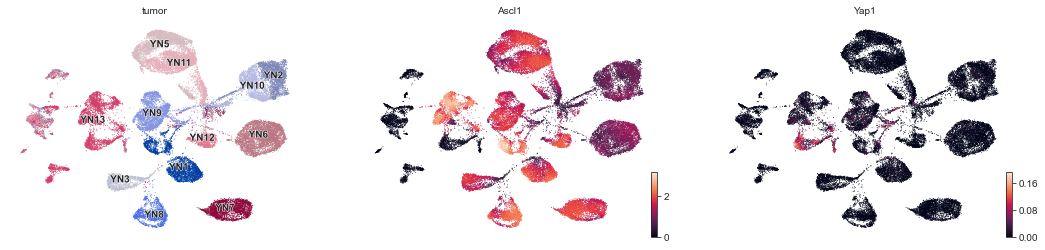

In [7]:
scv.pl.umap(adata, color = ['tumor','Ascl1','Yap1'], smooth = True, legend_loc = 'on data')

In [8]:
therapy_dict = {"Sensitive":['YN4','YN6','YN10','YN12'], 'More resistant':['YN11'], 'Resistant clone' : ['YN2'],
                "Resistant":['YN1','YN3','YN5','YN7','YN8','YN9'], 'TKO':['YN13']}

reverse_dict = {}
for i in therapy_dict.keys():
    for j in therapy_dict[i]:
        reverse_dict[j] = i

adata.obs['response'] = [reverse_dict[i] for i in adata.obs['tumor']]

In [9]:
allograft_id = {"YN1":"mt2", "YN2":"2LR","YN3":"mt3","YN5":"mt4","YN6":"5B","YN7":"mt5","YN8":"3L","YN9":"mt6",
               "YN10":"2L","YN11":"mt4Rf","YN12":"1L","YN13":"TKO-luc"}


adata.obs['allograft'] = [allograft_id[i] for i in adata.obs['tumor']]

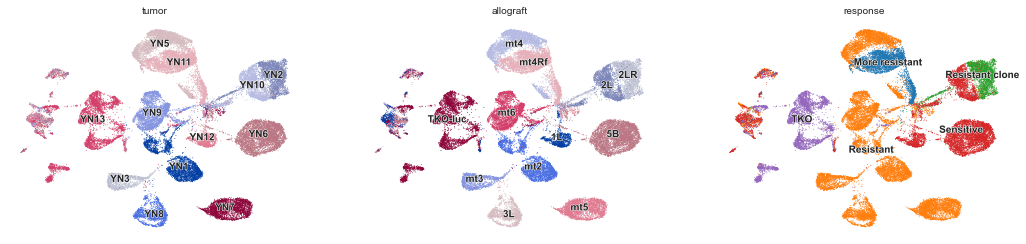

In [10]:
scv.pl.umap(adata, color = ['tumor','allograft','response'], smooth = True, legend_loc = 'on data')

In [ ]:
# mb.pp.scanorama_recipe(adata, groups = 'tumor', correct = True, basis = 'umap')


## MAGIC

For stronger PCHA, we'll run MAGIC.

In [11]:
import magic
# import pandas as pd
# import matplotlib.pyplot as plt
magic_operator = magic.MAGIC(solver='approximate')
X_magic = magic_operator.fit_transform(adata)


Calculating MAGIC...
  Running MAGIC on 37116 cells and 21200 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 39.31 seconds.
    Calculating KNN search...
    Calculated KNN search in 193.58 seconds.
    Calculating affinities...
    Calculated affinities in 202.91 seconds.
  Calculated graph and diffusion operator in 435.87 seconds.
  Calculating imputation...
  Calculated imputation in 0.17 seconds.
Calculated MAGIC in 442.70 seconds.


In [12]:
sc.pp.pca(X_magic)

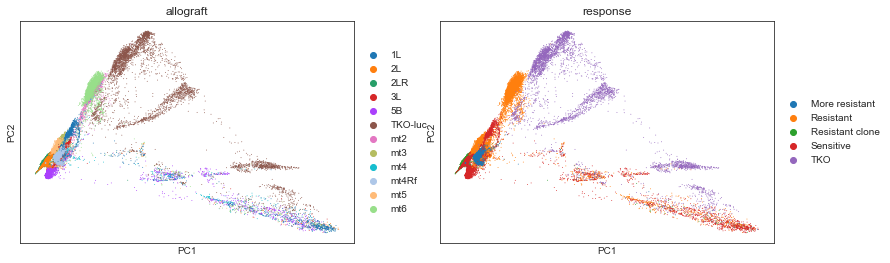

In [13]:
sc.pl.pca(X_magic, color=['allograft','response'])

In [14]:
scv.pp.neighbors(X_magic, random_state=0)
scv.tl.umap(X_magic, random_state=0)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


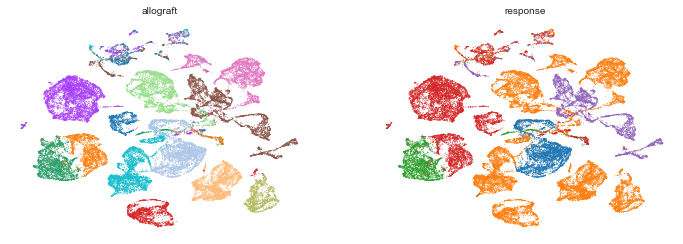

In [15]:
scv.pl.umap(X_magic,color=['allograft','response'])

In [16]:
X_magic

AnnData object with n_obs × n_vars = 37116 × 21200
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'response', 'allograft'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-YN1', 'dropkick_coef-YN10', 'dropkick_coef-YN11', 'dropkick_coef-YN12', 'dropkick_coef-YN13', 'dropkick_coef-YN2', 'dropkick_coef-YN3', 'dropkick_coef-YN5', 'dropkick_coef-YN6', 'dropkick_coef-YN7', 'dropkick_coef-YN8', 'dropkick_coef-YN9', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means'
    un

In [ ]:
adata.layers['imputed'] = X_magic.X
adata.obsm['X_pca_imputed'] = X_magic.obsm['X_pca']

In [ ]:
adata.write_h5ad("../../data/ta/external_validation/allografts.h5ad")